In [3]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamyearbyyearstats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
import numpy as np

In [4]:
# average points against each team for the specific year in the regular season to be manually entered
opponents_scores = [107.6, 108.4, 107.5, 104.3, 98.3, 99.9, 97.6, 95.0, 92.5, 96.0,
                    97.0, 99.3, 90.3, 90.1, 96.0, 88.4, 84.3, 90.4, 94.1, 97.2, 92.3]

In [5]:
# import manually made nba champions csv to df
champ_stats_df = pd.read_csv('Resources/champs_stats.csv')

In [6]:
# access nba api static endpoint to get team id
nba_teams = teams.get_teams()
all_champs = champ_stats_df['Team']
team_ids = {}
year = 2020
# loop through the team names in our df
for champ in all_champs:
    # search for team id using api and add to team_ids dict. The key used is the year the team won the championship
    # convert to string to add to dict and then convert back to int to make the next key the prior year
    team_ids[str(year)] = str([team for team in nba_teams if team["full_name"] == f'{champ}'][0]['id'])
    year = int(year) - 1

In [7]:
# getting all team hex colors and adding to dictionaries
primary_hex_colors = {}
secondary_hex_colors = {}
for champ in all_champs:
    primary_hex_colors[champ] = None
    secondary_hex_colors[champ] = None
    
primary_hex_colors['Los Angeles Lakers'] = '#f9a01b'
primary_hex_colors['Toronto Raptors'] = '#ce1141'
primary_hex_colors['Golden State Warriors'] = '#1d428a'
primary_hex_colors['Cleveland Cavaliers'] = '#860038'
primary_hex_colors['San Antonio Spurs'] = '#c4ced4'
primary_hex_colors['Miami Heat'] = '#98002e'
primary_hex_colors['Dallas Mavericks'] = '#00538c'
primary_hex_colors['Boston Celtics'] = '#007a33'
primary_hex_colors['Detroit Pistons'] = '#1d42ba'

secondary_hex_colors['Los Angeles Lakers'] = '#552583'
secondary_hex_colors['Toronto Raptors'] = '#a1a1a4'
secondary_hex_colors['Golden State Warriors'] = '#ffc72c'
secondary_hex_colors['Cleveland Cavaliers'] = '#041e42'
secondary_hex_colors['San Antonio Spurs'] = '#000000'
secondary_hex_colors['Miami Heat'] = '#f9a01b'
secondary_hex_colors['Dallas Mavericks'] = '#b8c4ca'
secondary_hex_colors['Boston Celtics'] = '#ba9653'
secondary_hex_colors['Detroit Pistons'] = '#c8102e'

In [8]:
# Note - team id is [0], city is [1], name is [2], Year is [3], GP is [4], wins is [5], win pct is [7], pts is [-2], lakers first on list is -5

# create dictionary and start from the 2019-2020 season
full_team_info = {}
i = -5

# Loop for each year and team id in my team_ids dict
for year, identity in team_ids.items():
    # return dict from nba_api endpoint
    team_info = teamyearbyyearstats.TeamYearByYearStats(league_id='00', per_mode_simple='Totals', season_type_all_star='Regular Season', team_id=identity).get_dict()
    # access the keys and lists of the returned dictionary to get our team info and stats to put into team_dict
    team_dict = {
        'City': team_info['resultSets'][0]['rowSet'][i:][0][1],
        'Team': team_info['resultSets'][0]['rowSet'][i:][0][2],
        'ID': str(team_info['resultSets'][0]['rowSet'][i:][0][0]),
        'Games Played': team_info['resultSets'][0]['rowSet'][i:][0][4],
        'Win %': team_info['resultSets'][0]['rowSet'][i:][0][7],
        'Points': team_info['resultSets'][0]['rowSet'][i:][0][-2]
    }
    # add the team_dict to the full_team info dict, with the year played as the key to avoid duplicate values
    year_played = team_info['resultSets'][0]['rowSet'][i:][0][3]
    full_team_info[year_played] = team_dict
    # decrease index to return info for previous year
    i = i-1

In [9]:
# create df and rename index column
full_team_stats_df = pd.DataFrame(full_team_info, index=None).T.reset_index()
full_team_stats_df = full_team_stats_df.rename(columns={'index': 'Year'})

# Create a column for points per game in regular season and round to 1 decimal place
full_team_stats_df['Points Per Game'] = full_team_stats_df['Points'] / full_team_stats_df['Games Played']
full_team_stats_df = full_team_stats_df.astype({'Points Per Game': 'float', 'Win %': 'float'})
full_team_stats_df['Points Per Game'] = full_team_stats_df['Points Per Game'].round(2)

# add the points against average from the first dataframe to our new df. And calculate the point differential between the averages
full_team_stats_df['Points Against Per Game'] = champ_stats_df['Points Against']
full_team_stats_df['Point Differential'] = (full_team_stats_df['Points Per Game'] - full_team_stats_df['Points Against Per Game']).round(2)

# adding team hex colors to df by matching key of dict to team name in df and then adding hex value for a match
full_team_stats_df['Hex Color Primary'] = (full_team_stats_df['City'] + ' ' + full_team_stats_df['Team']).map(primary_hex_colors)
full_team_stats_df['Hex Color Secondary'] = (full_team_stats_df['City'] + ' ' + full_team_stats_df['Team']).map(secondary_hex_colors)

# Combining name and year of teams
full_team_stats_df['Team and Year'] = full_team_stats_df['Year'] + ' ' + full_team_stats_df['Team']

# Convert win pct decimal to pct and round to 1 point
full_team_stats_df['Win %'] = (full_team_stats_df['Win %'] * 100).round(1)

# export the df to a csv
full_team_stats_df.to_csv('Resources/regular_season_stats_champs.csv', index=False, header=True)

In [10]:
# Note - playoff wins [10] losses [11]

pa_playoffs = [106.0, 101.1, 100.4, 105.8, 96.1, 95.5, 97.0, 90.7, 90.3, 92.5, 97.3, 95.2,
               88.8, 91.7, 92.5, 92.6, 80.7, 89.3, 94.1, 90.6, 97.4]
pf_playoffs = [112.8, 106.6, 110.4, 119.3, 104.8, 103.3, 106.3, 97.1, 97.3, 98.2, 101.1,
               102.4, 94.0, 95.7, 96.3, 96.9, 87.1, 94.8, 97.8, 103.4, 99.8]
full_team_info_playoffs = {}
i = -5

# Loop for each year and team id in my team_ids dict
for year, identity in team_ids.items():
    # return dict from nba_api endpoint
    team_info_playoffs = teamyearbyyearstats.TeamYearByYearStats(league_id='00', per_mode_simple='Totals', season_type_all_star='Regular Season', team_id=identity).get_dict()
    # access the keys and lists of the returned dictionary to get our team info and stats to put into team_dict
    team_dict_playoffs = {
        'ID': str(team_info_playoffs['resultSets'][0]['rowSet'][i:][0][0]),
        'Playoff Wins': team_info_playoffs['resultSets'][0]['rowSet'][i:][0][10],
        'Playoff Losses': team_info_playoffs['resultSets'][0]['rowSet'][i:][0][11],
    }
    # add the team_dict to the full_team info dict, with the year played as the key to avoid duplicate values
    year_played = team_info_playoffs['resultSets'][0]['rowSet'][i:][0][3]
    full_team_info_playoffs[year_played] = team_dict_playoffs
    # decrease index to return info for previous year
    i = i-1


In [11]:
# create df
full_team_stats_playoffs_df = pd.DataFrame(full_team_info_playoffs, index=None).T.reset_index()

# calculate playoff win %
full_team_stats_playoffs_df['Playoff Win %'] = ((full_team_stats_playoffs_df['Playoff Wins'] / (full_team_stats_playoffs_df['Playoff Wins'] + full_team_stats_playoffs_df['Playoff Losses'])) * 100)
full_team_stats_playoffs_df = full_team_stats_playoffs_df.astype({'Playoff Win %': 'float'})
full_team_stats_playoffs_df['Playoff Win %'] = full_team_stats_playoffs_df['Playoff Win %'].round(1)

# add points for (pf) and points against (pa) to df and then find playoff point differential
full_team_stats_playoffs_df['PF Playoffs'] = pf_playoffs
full_team_stats_playoffs_df['PA Playoffs'] = pa_playoffs
full_team_stats_playoffs_df['Playoff Point Differential'] = (full_team_stats_playoffs_df['PF Playoffs'] - full_team_stats_playoffs_df['PA Playoffs']).round(2)

# rename index to year
full_team_stats_playoffs_df = full_team_stats_playoffs_df.rename(columns={'index': 'Year'})

# export to csv
full_team_stats_playoffs_df.to_csv('Resources/playoffs_stats_champs.csv', index=False, header=True)

In [12]:
# merge regular season and playoff df to get win % and point differential for season and playoffs
full_season_df = pd.merge(full_team_stats_df, full_team_stats_playoffs_df[['Year', 'Playoff Win %', 'Playoff Point Differential']], on='Year')
full_season_df = full_season_df[['Team and Year', 'Win %', 'Point Differential', 'Playoff Win %', 'Playoff Point Differential', 'Hex Color Primary', 'Hex Color Secondary']]
full_season_df.to_csv('Resources/full_season_stats.csv', index=False, header=True)

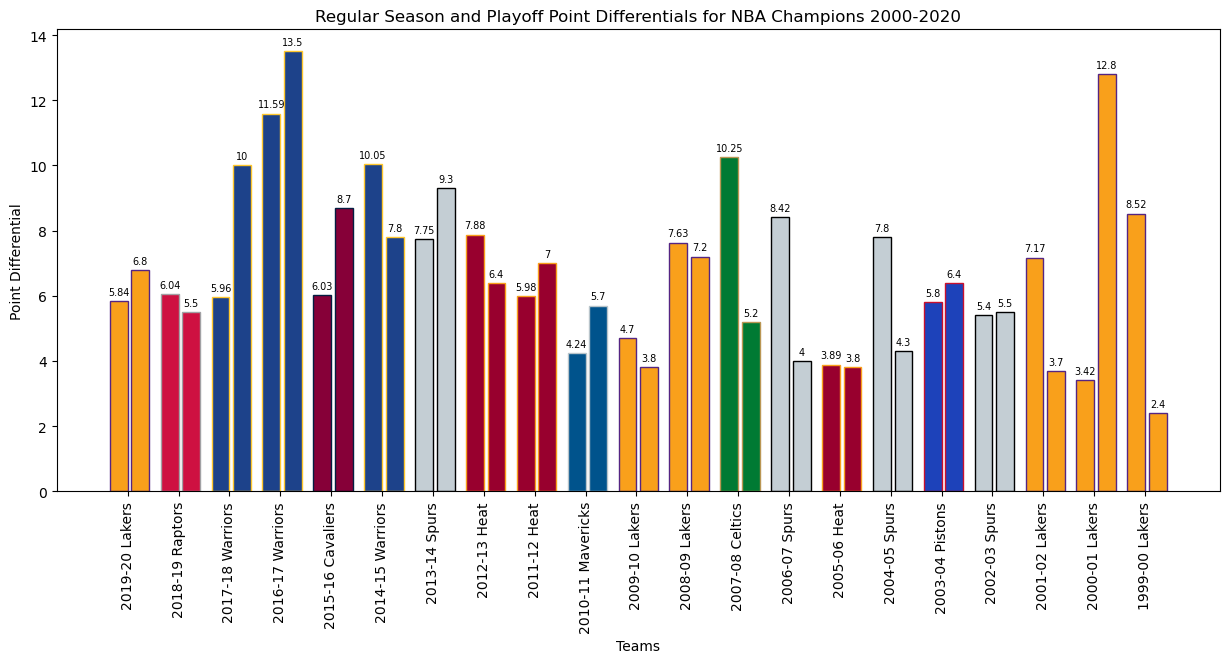

In [13]:
# Point differential plot for regular season and playoffs
championship_teams = full_season_df['Team and Year']
point_differentials = {
    'Regular Season': full_season_df['Point Differential'],
    'Playoffs': full_season_df['Playoff Point Differential']
}

# double bar code found in pyplot documentation
x = np.arange(len(championship_teams))
width = 0.35
multiplier = 0
bar_space = 0.075

fig, ax = plt.subplots(figsize=(15, 6))

for attribute, measurement in point_differentials.items():
    offset = (width + bar_space) * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=full_season_df['Hex Color Primary'], edgecolor=full_season_df['Hex Color Secondary'])
    ax.bar_label(rects, padding=3, fontsize=7)
    multiplier += 1

ax.set_ylabel('Point Differential')
ax.set_title('Regular Season and Playoff Point Differentials for NBA Champions 2000-2020')
ax.set_xlabel('Teams')
ax.set_xticks(x + width / 2, championship_teams, rotation=90)

plt.show()

Spearman Rank Correlation: 0.009099776830709807
P-value: 0.9687727351874544


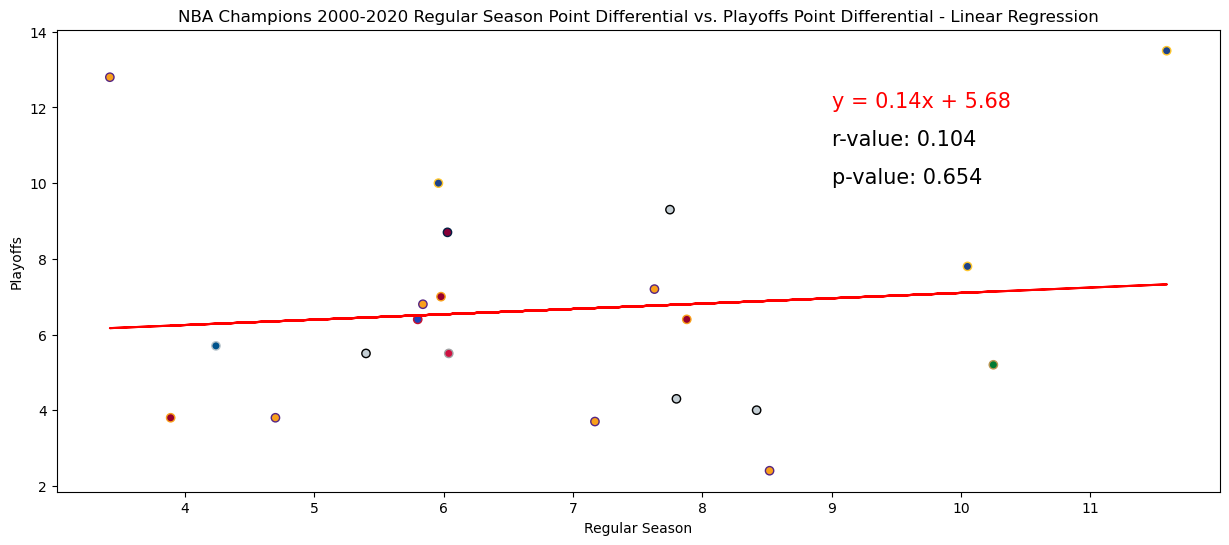

In [17]:
# scatter plot for point differential regular season vs playoffs
points_reg = full_season_df['Point Differential']
points_playoffs = full_season_df['Playoff Point Differential']

plt.figure(figsize=(15, 6))
plt.scatter(points_reg, points_playoffs, c=full_season_df['Hex Color Primary'], edgecolors=full_season_df['Hex Color Secondary'])

# linear regression and annotate with function, r-value, and p-value
(slope, intercept, rvalue, pvalue, stderr) = linregress(points_reg, points_playoffs)
regress_values = points_reg * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(points_reg, regress_values, "r-")
plt.annotate(line_eq, (9, 12), fontsize=15, color="red")
plt.annotate(f'r-value: {round(rvalue, 3)}', (9, 11), fontsize=15)
plt.annotate(f'p-value: {round(pvalue, 3)}', (9, 10), fontsize=15)

correlation, p_value = spearmanr(points_reg, points_playoffs)

print(f"Spearman Rank Correlation: {correlation}")
print(f"P-value: {p_value}")

plt.xlabel('Regular Season')
plt.ylabel('Playoffs')
plt.title('NBA Champions 2000-2020 Regular Season Point Differential vs. Playoffs Point Differential - Linear Regression')

plt.savefig('Figures/full_season_pointdiff_scatter.png')
plt.show()

Spearman Rank Correlation: -0.1824782154160109
P-value: 0.4285372758099645


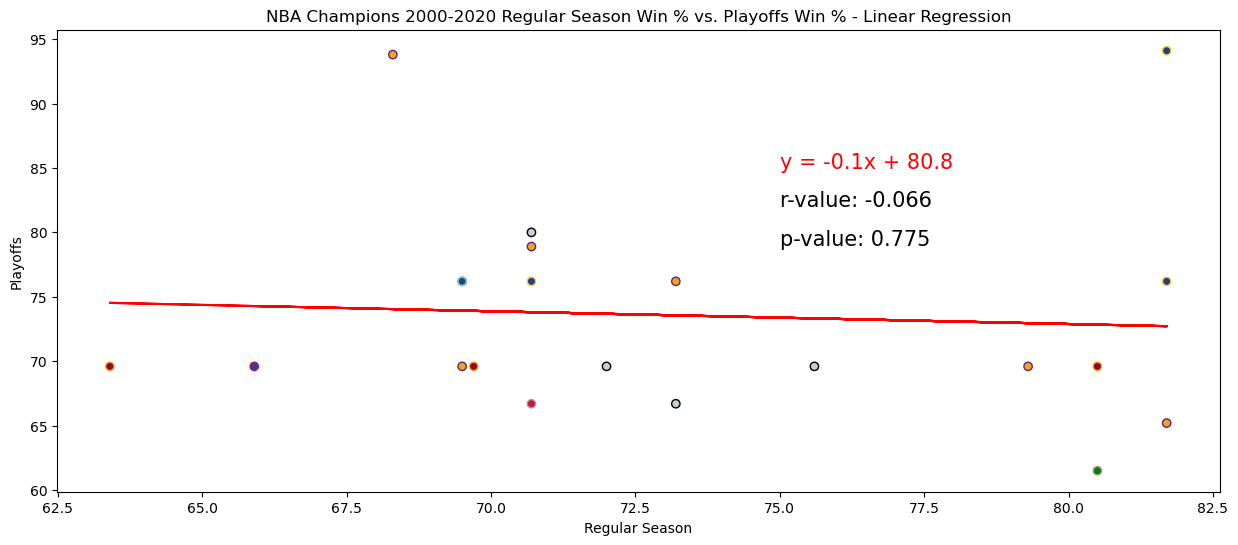

In [18]:
# scatter plot for win pct of regular season vs playoffs
win_pct_playoffs = full_season_df['Playoff Win %']
win_pct_reg = full_season_df['Win %']

plt.figure(figsize=(15, 6))
plt.scatter(win_pct_reg, win_pct_playoffs, c=full_season_df['Hex Color Primary'], edgecolors=full_season_df['Hex Color Secondary'])

# linear regression and annotate with function, r-value, and p-value
(slope, intercept, rvalue, pvalue, stderr) = linregress(win_pct_reg, win_pct_playoffs)
regress_values = win_pct_reg * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(win_pct_reg, regress_values, "r-")
plt.annotate(line_eq, (75, 85), fontsize=15, color="red")
plt.annotate(f'r-value: {round(rvalue, 3)}', (75, 82), fontsize=15)
plt.annotate(f'p-value: {round(pvalue, 3)}', (75, 79), fontsize=15)

correlation, p_value = spearmanr(win_pct_reg, win_pct_playoffs)

print(f"Spearman Rank Correlation: {correlation}")
print(f"P-value: {p_value}")

plt.xlabel('Regular Season')
plt.ylabel('Playoffs')
plt.title('NBA Champions 2000-2020 Regular Season Win % vs. Playoffs Win % - Linear Regression')

plt.savefig('Figures/full_season_winpct_scatter.png')
plt.show()

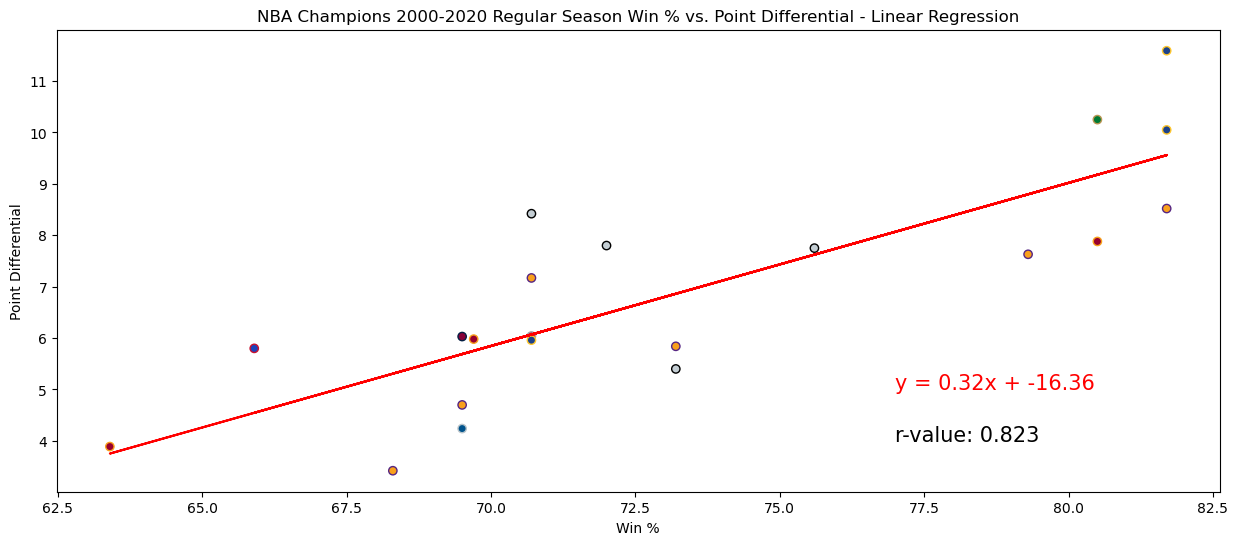

In [19]:
# scatter plot for regular season win pct vs. point differential
win_pct_reg = full_season_df['Win %']
championship_teams = full_season_df['Team and Year']
point_differential_reg = full_season_df['Point Differential']

# plot the scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(win_pct_reg, point_differential_reg, c=full_season_df['Hex Color Primary'], edgecolors=full_season_df['Hex Color Secondary'])

# linear regression and annotate with function and r-value
(slope, intercept, rvalue, pvalue, stderr) = linregress(win_pct_reg, point_differential_reg)
regress_values = win_pct_reg * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(win_pct_reg, regress_values, "r-")
plt.annotate(line_eq, (77, 5), fontsize=15, color="red")
plt.annotate(f'r-value: {round(rvalue, 3)}', (77, 4), fontsize=15)

plt.xlabel('Win %')
plt.ylabel('Point Differential')
plt.title('NBA Champions 2000-2020 Regular Season Win % vs. Point Differential - Linear Regression')

plt.savefig('Figures/regular_season_point_winpct_scatter.png')
plt.show()

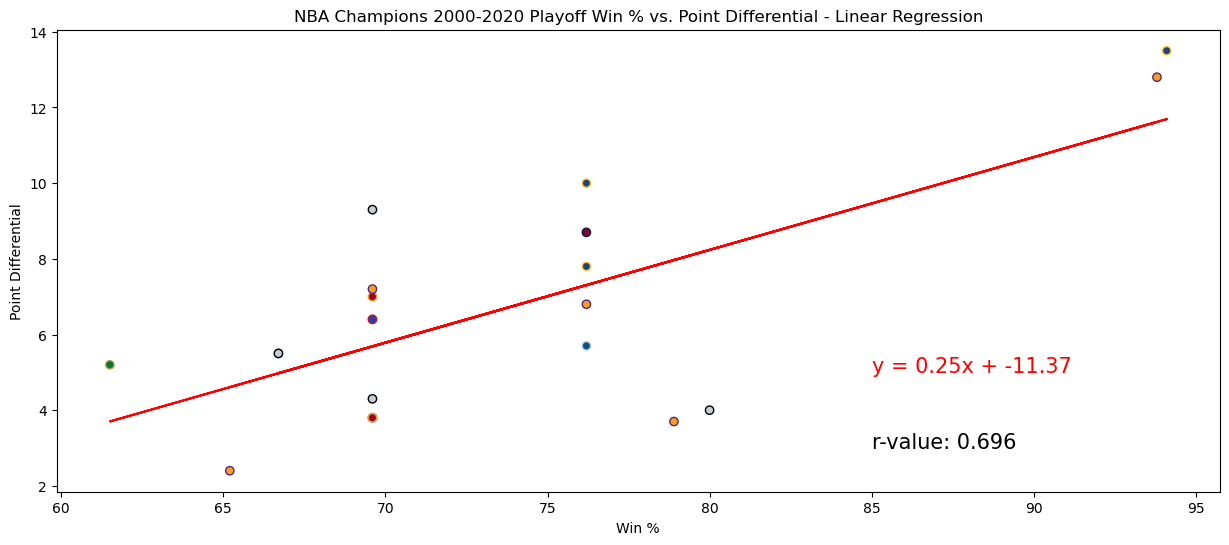

In [20]:
# scatter plot and linear regression for playoff win pct vs. point differential
win_pct_playoffs = full_season_df['Playoff Win %']
point_differential_playoffs = full_season_df['Playoff Point Differential']

# plot the scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(win_pct_playoffs, point_differential_playoffs, c=full_season_df['Hex Color Primary'], edgecolors=full_season_df['Hex Color Secondary'])

# linear regression and annotate with function and r-value
(slope, intercept, rvalue, pvalue, stderr) = linregress(win_pct_playoffs, point_differential_playoffs)
regress_values = win_pct_playoffs * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(win_pct_playoffs, regress_values, "r-")
plt.annotate(line_eq, (85, 5), fontsize=15, color="red")
plt.annotate(f'r-value: {round(rvalue, 3)}', (85, 3), fontsize=15)

plt.xlabel('Win %')
plt.ylabel('Point Differential')
plt.title('NBA Champions 2000-2020 Playoff Win % vs. Point Differential - Linear Regression')

plt.savefig('Figures/playoff_point_winpct_scatter.png')
plt.show()

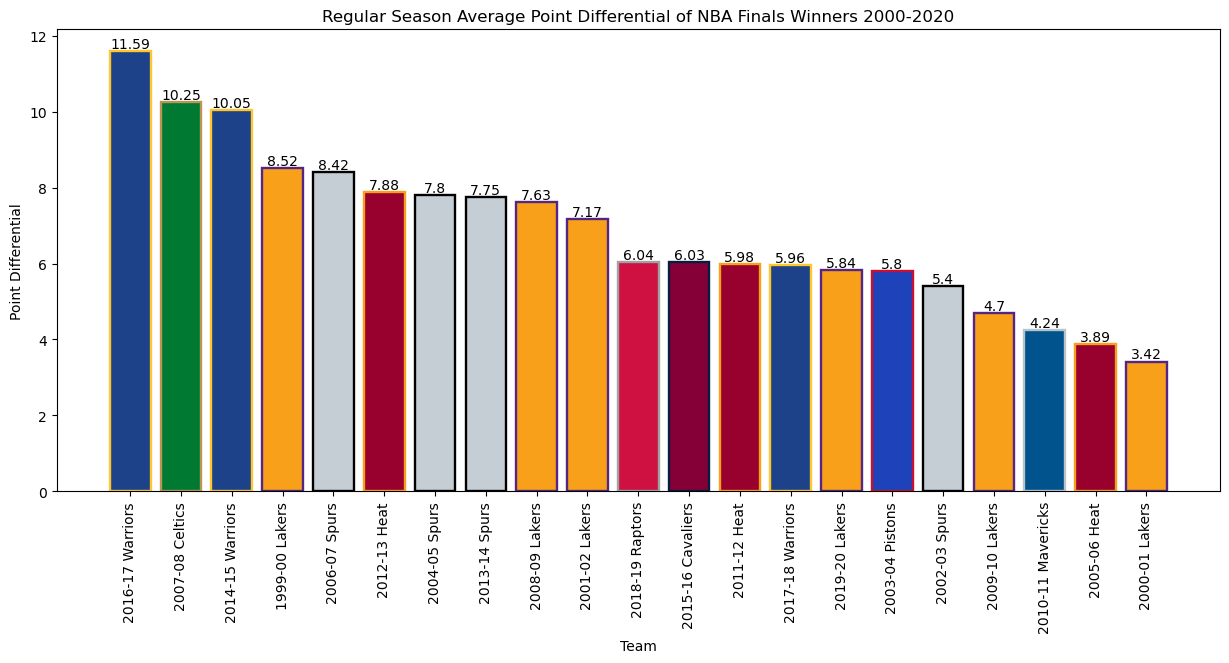

In [21]:
# Point regular season differential plot
# copy df to ignore the sort after we get our sorted data for bar graph
full_season_copy = full_season_df.copy()
full_season_copy = full_season_copy.sort_values(by=['Point Differential'], ascending=[False])
teams_analysis_reg = full_season_copy['Team and Year']
point_differential_reg = full_season_copy['Point Differential']
plt.figure(figsize=(15, 6))

# code from documentation to add values above the bars
bars = plt.bar(teams_analysis_reg, point_differential_reg, color=full_season_copy['Hex Color Primary'], edgecolor=full_season_copy['Hex Color Secondary'], linewidth=1.7)

plt.xticks(rotation=90)
plt.title('Regular Season Average Point Differential of NBA Finals Winners 2000-2020')
plt.xlabel('Team')
plt.ylabel('Point Differential')
plt.bar_label(bars)
plt.show()

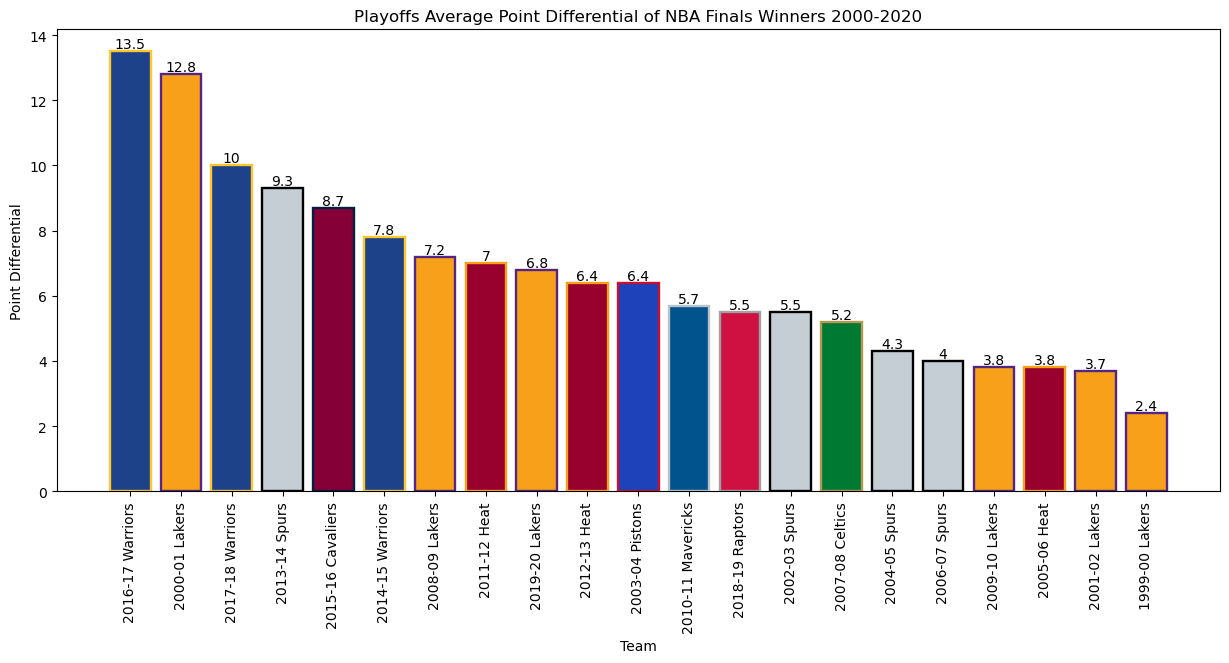

In [22]:
# plot playoff point differential plot
# copy df to ignore the sort after we get our sorted data for bar graph
full_season_copy = full_season_df.copy()
full_season_copy = full_season_copy.sort_values(by=['Playoff Point Differential'], ascending=[False])
championship_teams = full_season_copy['Team and Year']
point_differential_playoffs = full_season_copy['Playoff Point Differential']
plt.figure(figsize=(15, 6))

# code from documentation to add values above the bars
bars = plt.bar(championship_teams, point_differential_playoffs, color=full_season_copy['Hex Color Primary'], edgecolor=full_season_copy['Hex Color Secondary'], linewidth=1.7)

plt.xticks(rotation=90)
plt.title('Playoffs Average Point Differential of NBA Finals Winners 2000-2020')
plt.xlabel('Team')
plt.ylabel('Point Differential')
plt.bar_label(bars)
plt.show()